# Loading data and $0^{\text{th}}$ order EDA

In [3]:
# Load the required packages
import pandas as pd
import numpy as np
import tensorflow as tf

# plotting configs 
from matplotlib import pyplot as plt

import seaborn as sns
sns.set()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [4]:
# Read the original file
original_path = 'data/original.xlsx'
orig_xls = pd.ExcelFile(original_path)
print(orig_xls.sheet_names)

['Training_set_Staphiloccocus', 'Test_set_Staphiloccocus']


In [5]:
# import the excel sheets separately
df1 = orig_xls.parse('Training_set_Staphiloccocus')
df2 = orig_xls.parse('Test_set_Staphiloccocus')

In [6]:
# import the extra data that we have
additional_path = 'data/additional.xlsx'
addit_xls = pd.ExcelFile(additional_path)
print(addit_xls.sheet_names)

['Sheet1', 'Sheet2']


In [7]:
# there is one more column -- 'Sequence', that we remove to match the rest of the data
df3 = addit_xls.parse('Sheet1').drop(['Sequence'], axis=1)

In [8]:
print(df1.shape, df2.shape, df3.shape)

(298, 13) (74, 13) (52, 13)


In [9]:
# merge the three excel sheets into the training + validation data + test
df = pd.concat([df1, df2, df3], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Normalized Hydrophobic Moment                424 non-null    float64
 1   Normalized Hydrophobicity                    424 non-null    float64
 2   Net Charge                                   424 non-null    int64  
 3   Isoelectric Point                            424 non-null    float64
 4   Penetration Depth                            424 non-null    int64  
 5   Tilt Angle                                   424 non-null    int64  
 6   Propensity to Disordering                    424 non-null    float64
 7   Linear Moment                                424 non-null    float64
 8   Propensity to in vitro Aggregation           424 non-null    float64
 9   Angle Subtended by the Hydrophobic Residues  424 non-null    int64  
 10  Am

In [10]:
# check for duplicates
df.drop_duplicates(inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 0 to 423
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Normalized Hydrophobic Moment                408 non-null    float64
 1   Normalized Hydrophobicity                    408 non-null    float64
 2   Net Charge                                   408 non-null    int64  
 3   Isoelectric Point                            408 non-null    float64
 4   Penetration Depth                            408 non-null    int64  
 5   Tilt Angle                                   408 non-null    int64  
 6   Propensity to Disordering                    408 non-null    float64
 7   Linear Moment                                408 non-null    float64
 8   Propensity to in vitro Aggregation           408 non-null    float64
 9   Angle Subtended by the Hydrophobic Residues  408 non-null    int64  
 10  Am

### $\color{red}{\textbf{Correlations bewteen features}}$

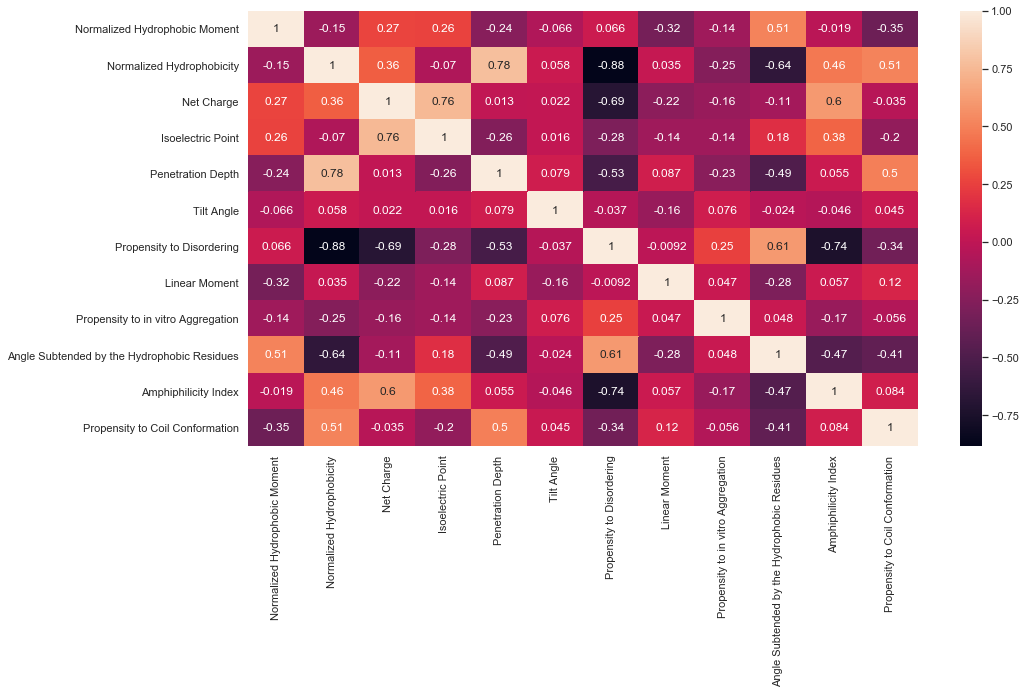

In [12]:
# Correlation matrix 
plt.figure(figsize=(15,8))
corr_mat = df.drop('Class', axis=1).corr()
sns.heatmap(corr_mat, annot=True)
plt.show()

In [13]:
# The strongest correlation is between 'Propensity to Disordering' and 'Normalized Hydrophobicity'
unwrapped = np.abs(corr_mat.values.reshape((1,-1)))
max_abs_cor = unwrapped[unwrapped < 1].max()
print(max_abs_cor)

0.8819973411717638


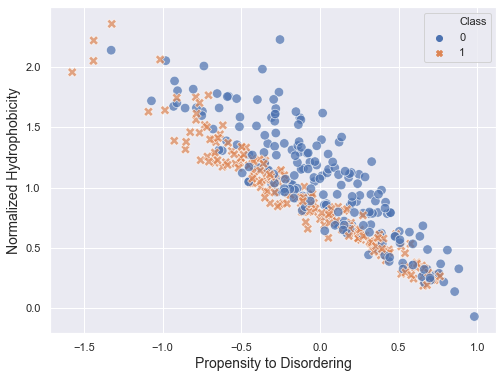

In [14]:
sns.scatterplot(x = 'Propensity to Disordering', y = 'Normalized Hydrophobicity', hue = 'Class', 
                style = 'Class', data = df, s = 90, alpha = 0.7)
plt.xlabel('Propensity to Disordering', fontsize = 14)
plt.ylabel('Normalized Hydrophobicity', fontsize = 14)
plt.show()

### $\color{red}{\textbf{PCA}}$

In [15]:
# Let's check if one can reduce dimensionality. For PCA to make sense, standardize data!
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

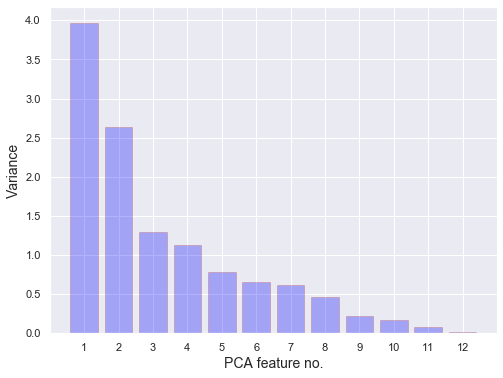

In [16]:
pca_transformer = PCA()
stdzed_raw_data = StandardScaler().fit_transform(df.drop(['Class'], axis=1).values)
pca_transformer.fit(stdzed_raw_data)
pca_feat_matrix = pca_transformer.transform(stdzed_raw_data)
features = range(1, pca_transformer.n_components_ + 1)
plt.bar(features, pca_transformer.explained_variance_, color='blue', edgecolor='r', alpha=0.3)
plt.xticks(features)
plt.xlabel('PCA feature no.', fontsize = 14)
plt.ylabel('Variance', fontsize = 14)
plt.show()

In [17]:
# The data is NOT lower-dimensional, but let's anyway check if the 2-component PCA would separate classes

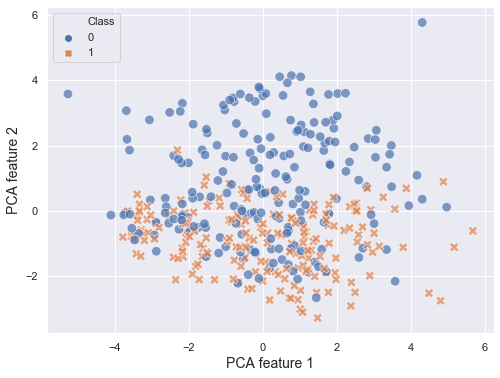

In [18]:
pca_transformer = PCA(n_components=2)
stdzed_raw_data = StandardScaler().fit_transform(df.drop(['Class'], axis=1).values)
pca_transformer.fit(stdzed_raw_data)
pca_feat_matrix = pca_transformer.transform(stdzed_raw_data)
features = range(1, pca_transformer.n_components_ + 1)
sns.scatterplot(x = pca_feat_matrix[:,0], y = pca_feat_matrix[:,1], hue = df['Class'], style = df['Class'], marker='o', 
            s=90, alpha=0.7)
plt.xlabel('PCA feature 1', fontsize=14)
plt.ylabel('PCA feature 2', fontsize =14)
plt.show()

# Fitting and predicting with a shallow NN in Keras

In [19]:
#########  start: prepare train and test data #########

In [30]:
# split into features and labels (and transform to np arrays)
X = df.drop(['Class'], axis=1).values
y = df['Class'].values
print(X.shape, y.shape)

(408, 12) (408,)


In [31]:
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train_raw.shape, X_test_raw.shape)
print(y_train.shape, y_test.shape)

(326, 12) (82, 12)
(326,) (82,)


In [32]:
# standardize

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_raw)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [34]:
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [35]:
print(X_train.shape, X_test_raw.shape)
print(y_train.shape, y_test.shape)

(326, 12) (82, 12)
(326,) (82,)


In [36]:
#########  end: prepare train and test data #########

In [37]:
#########  start: define a keras DNN model #########

In [38]:
# define the model

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_dim=12, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy');
history = model.fit(X_train, y_train, epochs=85, validation_data=(X_test, y_test));

Epoch 1/85
11/11 [==============================] - 0s 14ms/step - loss: 0.7623 - accuracy: 0.4908 - val_loss: 0.6807 - val_accuracy: 0.5488
Epoch 2/85
11/11 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.5798 - val_loss: 0.6171 - val_accuracy: 0.6951
Epoch 3/85
11/11 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6104 - val_loss: 0.5697 - val_accuracy: 0.7927
Epoch 4/85
11/11 [==============================] - 0s 3ms/step - loss: 0.6082 - accuracy: 0.6718 - val_loss: 0.5301 - val_accuracy: 0.7927
Epoch 5/85
11/11 [==============================] - 0s 3ms/step - loss: 0.5879 - accuracy: 0.6687 - val_loss: 0.4975 - val_accuracy: 0.7805
Epoch 6/85
11/11 [==============================] - 0s 3ms/step - loss: 0.5615 - accuracy: 0.7301 - val_loss: 0.4696 - val_accuracy: 0.7927
Epoch 7/85
11/11 [==============================] - 0s 3ms/step - loss: 0.5201 - accuracy: 0.7393 - val_loss: 0.4468 - val_accuracy: 0.7927
Epoch 8/85
11/11 [=

11/11 [==============================] - 0s 3ms/step - loss: 0.3757 - accuracy: 0.8221 - val_loss: 0.4071 - val_accuracy: 0.8293
Epoch 60/85
11/11 [==============================] - 0s 3ms/step - loss: 0.3699 - accuracy: 0.8344 - val_loss: 0.4142 - val_accuracy: 0.8293
Epoch 61/85
11/11 [==============================] - 0s 3ms/step - loss: 0.3420 - accuracy: 0.8405 - val_loss: 0.4200 - val_accuracy: 0.8171
Epoch 62/85
11/11 [==============================] - 0s 3ms/step - loss: 0.3698 - accuracy: 0.8252 - val_loss: 0.4181 - val_accuracy: 0.8171
Epoch 63/85
11/11 [==============================] - 0s 3ms/step - loss: 0.3606 - accuracy: 0.8221 - val_loss: 0.4151 - val_accuracy: 0.8171
Epoch 64/85
11/11 [==============================] - 0s 3ms/step - loss: 0.3466 - accuracy: 0.8405 - val_loss: 0.4148 - val_accuracy: 0.8049
Epoch 65/85
11/11 [==============================] - 0s 3ms/step - loss: 0.3552 - accuracy: 0.8221 - val_loss: 0.4154 - val_accuracy: 0.7927
Epoch 66/85
11/11 [======

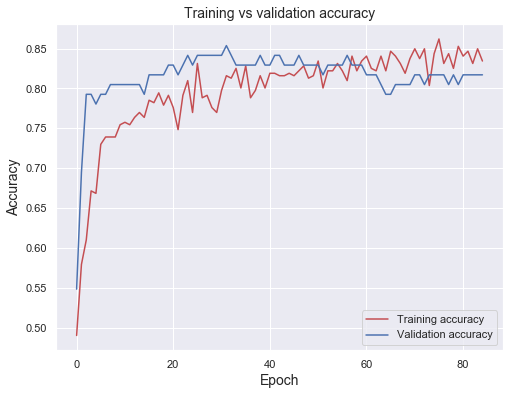

<Figure size 576x432 with 0 Axes>

In [42]:
# plot training vs validation accuracy

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training vs validation accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc=0)
plt.figure()
plt.show();

In [43]:
# the model's loss and accuracy
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 0.4506 - accuracy: 0.8171


[0.4505634903907776, 0.8170731663703918]

In [44]:
# prediction and 
from sklearn.metrics import classification_report

y_pred = (model.predict(X_test) > 0.5).flatten()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        44
           1       0.81      0.79      0.80        38

    accuracy                           0.82        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.82      0.82      0.82        82



In [45]:
model.save('NN_model_1.h5')  # creates a HDF5 file 'model.h5'
del model  # deletes the existing model (can be loaded back by model = load_model('filename'))

In [106]:
# in addition to the model, we need to safe the sklearn scaler (can be loaded back with scaler = pickle.load(open('scaler.pkl','rb')))
import pickle
pickle.dump(scaler, open('scaler.pkl','wb'))

In [107]:
del scaler

### Scratchwork

In [ ]:
# check how stable the predictions of different models are

In [108]:
import pickle
from tensorflow.keras.models import load_model

scaler = pickle.load(open('scaler.pkl','rb'))
model = load_model('NN_model_1.h5')

In [115]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [116]:
y_pred = (model.predict(X_test) > 0.5).flatten()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80        34
           1       0.84      0.90      0.87        48

    accuracy                           0.84        82
   macro avg       0.84      0.83      0.83        82
weighted avg       0.84      0.84      0.84        82



In [117]:
y_pred = (model.predict(X_train) > 0.5).flatten()
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       170
           1       0.81      0.92      0.86       156

    accuracy                           0.86       326
   macro avg       0.87      0.86      0.86       326
weighted avg       0.87      0.86      0.86       326

